In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error



from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import shapiro
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

import warnings
from scipy import stats
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.neighbors")

In [3]:
data1 = pd.read_excel('final_data.xlsx')

In [8]:
data_temp = .head()

,Unnamed: 0,Name,Hg,N,ELV,SA,Z,LT,ST,DA,...,FR,DAM,LAT1,LAT2,LAT3,LONG1,LONG2,LONG3,Latitude_decimal,Longitude_decimal
0,0,ALLIGATOR.P,0.025,2,1494,47,26,2,0,1,...,0.8,1,45,37,50,69,12,30,45.630556,-69.203333
1,29,DIMMICK.P(LITTLE),0.050,4,1390,41,14,2,0,4,...,19.4,1,45,13,45,69,52,25,45.229167,-69.881111
2,46,HOSMER.P,0.071,3,212,53,16,3,0,2,...,6.8,0,44,12,53,69,7,44,44.214722,-69.118611
3,74,PENNINGTON.P,0.080,2,904,45,5,2,0,1,...,17.5,1,46,56,10,68,31,11,46.936111,-68.525278
4,47,INDIAN.P(BIG),0.090,4,1209,280,68,1,1,5,...,0.9,1,45,26,20,69,44,12,45.438889,-69.745556


In [6]:
# making some additional data transformation to help us build a predictive model. 

# Convert latitude and longitude from DMS (degrees, minutes, seconds) to decimal format
data1['Latitude_decimal'] = data1['LAT1'] + data1['LAT2'] / 60 + data1['LAT3'] / 3600
data1['Longitude_decimal'] = -(data1['LONG1'] + data1['LONG2'] / 60 + data1['LONG2'] / 3600)

# Drop the original latitude and longitude columns
data2 = data1.drop(columns=['LAT1', 'LAT2', 'LAT3', 'LONG1', 'LONG2', 'LONG3'])

#data2.to_excel('lakes_data_predictive.xlsx', index=False)

In [12]:
#data2 = data2.drop('Unnamed: 0', axis = 1)
data2.to_excel('lakes_data_predictive.xlsx', index=False)
data2.head()

In [14]:
data2.head()

,Name,Hg,N,ELV,SA,Z,LT,ST,DA,RF,FR,DAM,Latitude_decimal,Longitude_decimal
0,ALLIGATOR.P,0.025,2,1494,47,26,2,0,1,0.69,0.8,1,45.630556,-69.203333
1,DIMMICK.P(LITTLE),0.050,4,1390,41,14,2,0,4,0.66,19.4,1,45.229167,-69.881111
2,HOSMER.P,0.071,3,212,53,16,3,0,2,0.62,6.8,0,44.214722,-69.118611
3,PENNINGTON.P,0.080,2,904,45,5,2,0,1,0.51,17.5,1,46.936111,-68.525278
4,INDIAN.P(BIG),0.090,4,1209,280,68,1,1,5,0.76,0.9,1,45.438889,-69.745556


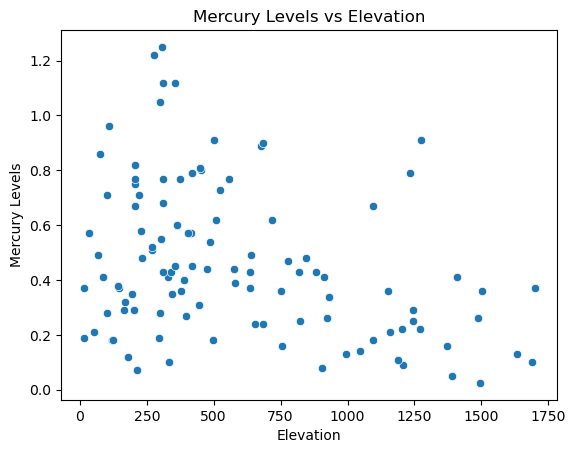

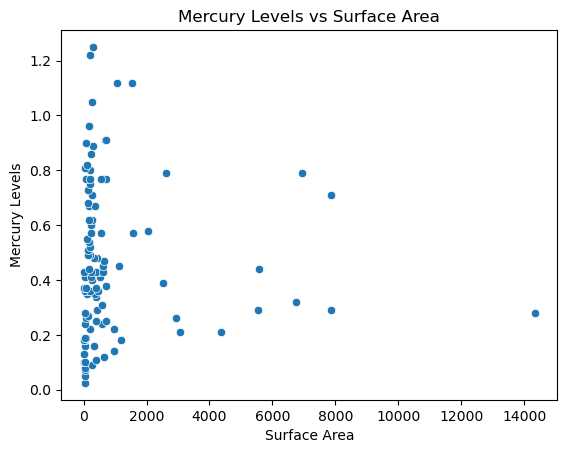

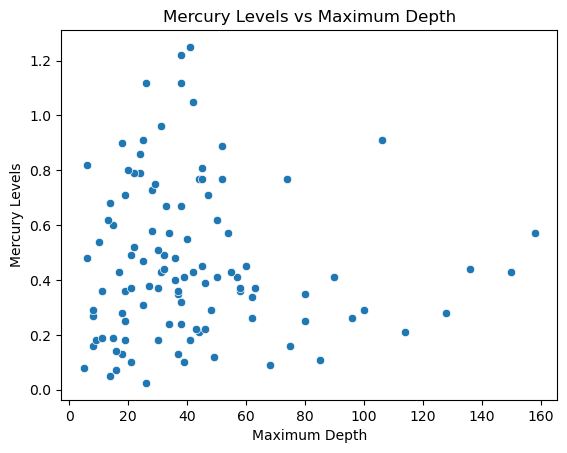

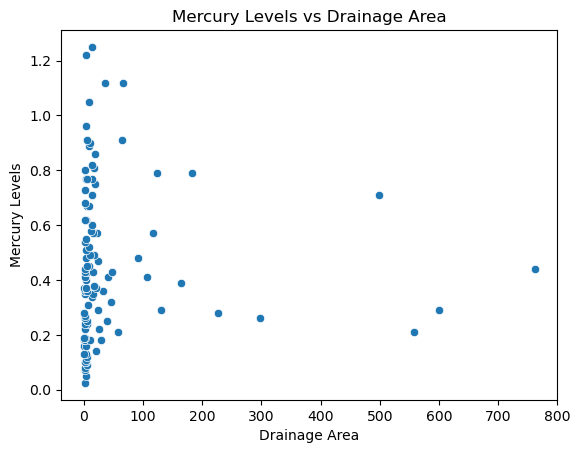

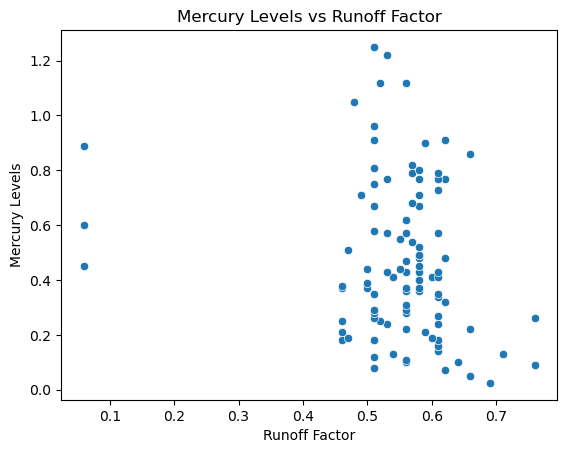

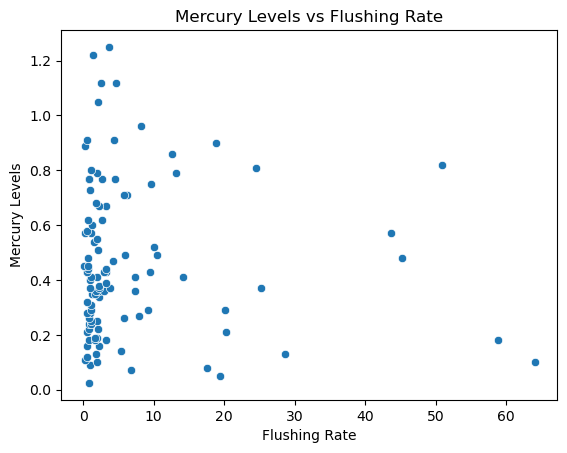

In [18]:
# let us visualize the data and check for correlations between the predictors and the response variables

# Continuous variables
continuous_vars = ['ELV', 'SA', 'Z', 'DA', 'RF', 'FR']
predictor_names = {'ELV': 'Elevation', 'SA': 'Surface Area', 'Z': 'Maximum Depth', 'DA': 'Drainage Area', 'RF': 'Runoff Factor', 'FR': 'Flushing Rate', 'LT': 'Lake Type', 'ST': 'Lake Stratification Indicator', 'DAM': 'Dam Present'}
# Visualize the relationship between mercury levels and continuous variables using scatter plots
for var in continuous_vars:
    plt.figure()
    sns.scatterplot(data = data2, x = var, y='Hg')

    plt.title(f'Mercury Levels vs {predictor_names[var]}')
    plt.xlabel(predictor_names[var])
    plt.ylabel('Mercury Levels')

plt.show()

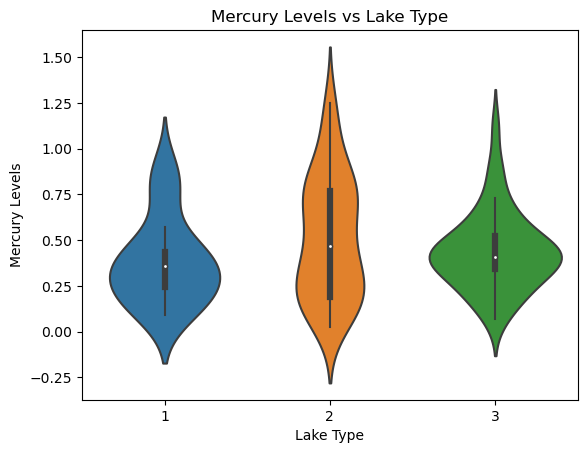

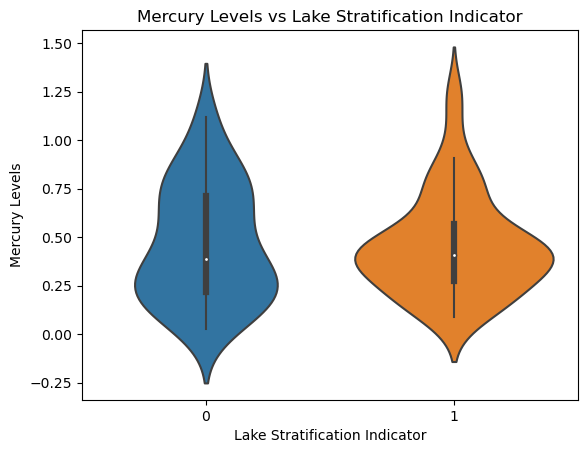

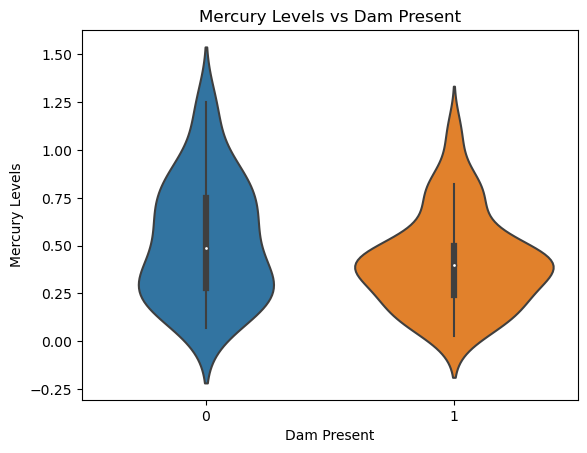

In [19]:
# For categorical Variables
categorical_vars = ['LT', 'ST', 'DAM']

# Visualize the relationship between mercury levels and categorical variables using violin plots
for var in categorical_vars:
    plt.figure()
    sns.violinplot(data = data2, x = var, y='Hg', inner='box')
    plt.title(f'Mercury Levels vs {predictor_names[var]}')
    plt.xlabel(predictor_names[var])
    plt.ylabel('Mercury Levels')

# Display the plots
plt.show()

In [34]:
# Feature Selection\

# One-hot encoding for the 'Lake Type' feature
data3 = pd.get_dummies(data2, columns=['LT'], prefix='Lake_Type')

y = data3['Hg']
X = data3.drop('Hg', axis = 1)
X = X.drop('Name', axis = 1)

In [35]:
def stepwise_regression(X, y):
    estimator = LinearRegression()
    selector = RFECV(estimator, step=1, cv=5, scoring='neg_mean_squared_error')
    selector.fit(X, y)

    significant_predictors = X.columns[selector.support_]
    return significant_predictors

def lasso_regression(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_scaled, y)

    coefficients = lasso.coef_
    significant_predictors = X.columns[np.abs(coefficients) > 0]
    return significant_predictors

def ridge_regression(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    ridge = RidgeCV(cv=5)
    ridge.fit(X_scaled, y)

    coefficients = ridge.coef_
    significant_predictors = X.columns[np.abs(coefficients) > 0]
    return significant_predictors


In [37]:
X

,N,ELV,SA,Z,ST,DA,RF,FR,DAM,Latitude_decimal,Longitude_decimal,Lake_Type_1,Lake_Type_2,Lake_Type_3
0,2,1494,47,26,0,1,0.69,0.8,1,45.630556,-69.203333,0,1,0
1,4,1390,41,14,0,4,0.66,19.4,1,45.229167,-69.881111,0,1,0
2,3,212,53,16,0,2,0.62,6.8,0,44.214722,-69.118611,0,0,1
3,2,904,45,5,0,1,0.51,17.5,1,46.936111,-68.525278,0,1,0
4,4,1209,280,68,1,5,0.76,0.9,1,45.438889,-69.745556,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,5,298,281,42,1,8,0.48,2.1,1,45.310000,-68.050833,0,1,0
104,5,354,1050,38,0,35,0.52,2.5,0,45.661111,-68.305000,0,1,0
105,5,311,1539,26,0,66,0.56,4.7,1,45.127500,-68.000000,0,0,1
106,5,276,210,38,1,3,0.53,1.4,0,43.820000,-70.321944,0,1,0


In [36]:
stepwise_predictors = stepwise_regression(X, y)
lasso_predictors = lasso_regression(X, y)
ridge_predictors = ridge_regression(X, y)

print("Significant predictors (Stepwise Regression):", stepwise_predictors)
print("Significant predictors (LASSO):", lasso_predictors)
print("Significant predictors (Ridge Regression):", ridge_predictors)

Significant predictors (Stepwise Regression): Index(['RF', 'DAM', 'Latitude_decimal', 'Longitude_decimal', 'Lake_Type_2'], dtype='object')
Significant predictors (LASSO): Index(['ELV', 'RF', 'DAM', 'Lake_Type_2'], dtype='object')
Significant predictors (Ridge Regression): Index(['N', 'ELV', 'SA', 'Z', 'ST', 'DA', 'RF', 'FR', 'DAM',
       'Latitude_decimal', 'Longitude_decimal', 'Lake_Type_1', 'Lake_Type_2',
       'Lake_Type_3'],
      dtype='object')


In [47]:
# From the above results we see that: There is no conclusive evidence on which predictors to select
# We keep all the predictors

selected_predictors = lasso_predictors

Mean Squared Error: 0.05534989886627377
R2 Score: 0.2270538678650753


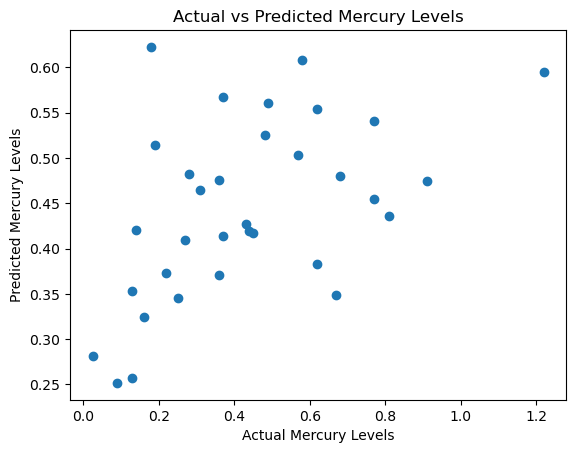

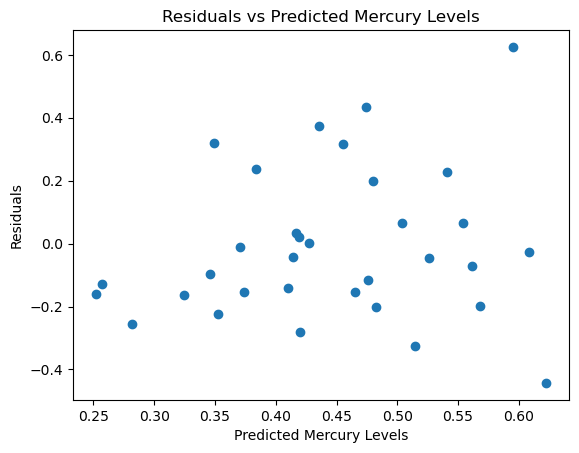

Shapiro-Wilk Test p-value: 0.1257806122303009
Residuals are normally distributed.


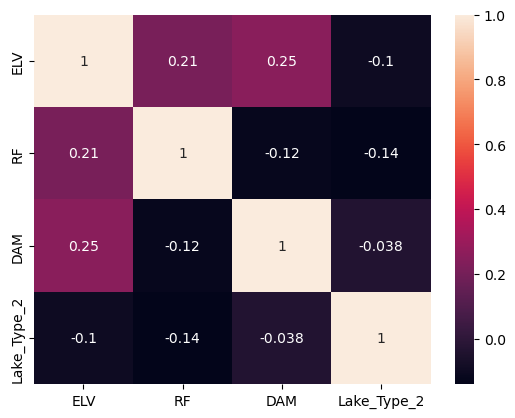

In [48]:
X_selected = X[selected_predictors]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Define the pipeline with StandardScaler and LinearRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regression', LinearRegression())
])

# Train the model using the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)

# Check for linearity assumption using scatter plots
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Mercury Levels")
plt.ylabel("Predicted Mercury Levels")
plt.title("Actual vs Predicted Mercury Levels")
plt.show()

# Check for homoscedasticity using residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Mercury Levels")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Mercury Levels")
plt.show()

# Check for normality of residuals using the Shapiro-Wilk test
stat, p_value = shapiro(residuals)
print("Shapiro-Wilk Test p-value:", p_value)
if p_value > 0.05:
    print("Residuals are normally distributed.")
else:
    print("Residuals are not normally distributed.")

# To check multicollinearity, calculate the correlation matrix of the features
corr_matrix = X_selected.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

# If the assumptions are not met, consider transforming the data or using a different model

In [50]:
# Decision Tree
X_selected = X[lasso_predictors]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Create a DecisionTreeRegressor and fit the model
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R2 Score:", r2)

Mean Squared Error: 0.09293351515151516
R2 Score: -0.29779100871737385


In [88]:
# adding a column to indicate if the mercury levels is above the threshold or not
data4 = data2.copy()
data4['Hg_High'] = (data4['Hg'] > 0.43).astype(int)
data4 = data4.drop(columns = ['Name', 'Hg'])
data4.iloc[50:70]

,N,ELV,SA,Z,LT,ST,DA,RF,FR,DAM,Latitude_decimal,Longitude_decimal,Hg_High
50,5,578,2515,46,3,0,164,0.50,3.3,1,47.087778,-68.305000,0
51,5,390,271,36,3,1,3,0.58,0.9,1,44.923611,-68.254167,0
52,5,1409,30,50,3,1,1,0.61,1.9,1,44.798889,-70.965833,0
53,5,328,47,39,3,1,1,0.54,1.1,1,44.281944,-70.271111,0
54,3,87,532,57,3,1,106,0.60,14.2,0,44.257222,-69.254167,0
55,5,913,225,90,1,1,41,0.61,7.3,1,45.745278,-69.186389,0
56,3,341,467,55,1,1,4,0.58,0.5,1,44.900000,-68.237222,0
57,5,819,403,31,3,1,47,0.58,9.5,1,46.407222,-69.033889,0
58,2,634,227,150,1,1,6,0.53,0.5,1,45.751111,-69.067778,0
59,5,312,29,42,3,1,1,0.56,3.3,1,44.402500,-69.389722,0


In [89]:
# Select features and target variable
X = data4.drop(['Hg_High'], axis=1)
y = data4['Hg_High']
#X = X[selected_predictors]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the models
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('SVM', SVC()),
    ('KNN', KNeighborsClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Random Forest', RandomForestClassifier()),
]

# Train and evaluate the models
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.56      0.78      0.65        18
           1       0.50      0.27      0.35        15

    accuracy                           0.55        33
   macro avg       0.53      0.52      0.50        33
weighted avg       0.53      0.55      0.51        33

Decision Tree Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.64      0.78      0.70        18
           1       0.64      0.47      0.54        15

    accuracy                           0.64        33
   macro avg       0.64      0.62      0.62        33
weighted avg       0.64      0.64      0.63        33

SVM Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.59      0.89      0.71        18
           1       0.67      0.27      0.38        15

    accuracy                           0.61        33
   macro avg       0.63      0.58      0.55  

In [73]:
for name, model in models:
    print(name)

Logistic Regression
Decision Tree
Random Forest
Gradient Boosting
